# RF vs Gradient Boosted Trees (with XGBoost)

Materials for the lecture on "RF in the supervised learning landscape", ECAS-SFdS 2023 School on "Random Forests: basics, extensions, and applications".

To open this notebook in Google Colabotary, click [here](https://drive.google.com/file/d/1NSNLUhp8ApBcH1QmqP9mgWndTSSBzMEe/view?usp=sharing)


__Author:__ Pierre Geurts, p.geurts@uliege.be

> __Credits__: some parts of this notebook are adapted from the notebook here:
https://github.com/pprett/pydata-gbrt-tutorial. Instead of using scikit-learn's implementation of gradient boosting, we however use [XGBoost](https://github.com/dmlc/xgboost).

The practical is divided into three parts:
* As a preambule, we first compare several tree-based models on a synthetic classification problem.
* Then, we let you study the impact of XGBoost's main hyper-parameters on a simple one-dimensional regression problem.
* Finally, we propose one real classification task on which we encourage you to try to tune RF and XGBoost to obtain the best possible performance.

For simplicity, we will be using the scikit-learn interface of XGBoost. XGBoost also offers its own interface in python (as well as in R). If you want to know more about XGBoost, you can acccess the full documentation [here](https://xgboost.readthedocs.io/en/stable/).


In [ ]:
# uncomment if you are on google colab
# !pip install xgboost scikit-learn pandas numpy matplotlib

# Preambule: classifiers comparison


To get a feeling about the different tree-based methods available in scikit-learn and XGBoost, let us make a first comparison of the following models with default hyper-parameter settings:
* RandomForestClassifier
* ExtraTreesClassifier: a variant of RF introducing more randomization.
* GradientBoostingClassifier: the official implementation of gradient boosting in scikit-learn.
* HistGradientBoostingClassifier: a more efficient implementation using binning for the numerical variables.
* XGBClassifier: XGBoost.
* XGBRFClassifier: XGBoost's implementation of RF. The main difference w.r.t. regular RF is that bootstrapping is replaced by sampling without replacement.
* MLPClassifier: a simple neural network classifier from scikit-learn.




In [ ]:
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from time import process_time

RS = 12345

In [ ]:
estimator_list = [RandomForestClassifier(random_state=RS), ExtraTreesClassifier(random_state=RS),
                  GradientBoostingClassifier(random_state=RS), HistGradientBoostingClassifier(random_state=RS),
                  XGBClassifier(random_state=RS), XGBRFClassifier(random_state=RS), MLPClassifier(random_state=RS)]

# We will use an artificial dataset generator from scikit-learn

from sklearn.datasets import make_hastie_10_2
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Generate synthetic classification data

X, y = make_classification(
    n_samples=5000,
    n_features=10,
    n_informative=5,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    random_state=RS,
    shuffle=False,
)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
results = pd.DataFrame(columns=["Estimator", "Train Acc", "Test Acc", "cpu"])
for est in estimator_list:
    print("Fitting ", est.__class__.__name__,"...")
    t_start = process_time()
    est.fit(X_train, y_train)
    t_stop = process_time()
    results.loc[len(results)] = {"Estimator": est.__class__.__name__,
                                 "Train Acc": est.score(X_train, y_train),
                                 "Test Acc": est.score(X_test, y_test),
                                 "cpu": t_stop-t_start}
results

Fitting  RandomForestClassifier ...
Fitting  ExtraTreesClassifier ...
Fitting  GradientBoostingClassifier ...
Fitting  HistGradientBoostingClassifier ...
Fitting  XGBClassifier ...
Fitting  XGBRFClassifier ...
Fitting  MLPClassifier ...


,Estimator,Train Acc,Test Acc,cpu
0,RandomForestClassifier,1.000000,0.9224,1.127296
1,ExtraTreesClassifier,1.000000,0.9312,0.373976
2,GradientBoostingClassifier,0.936800,0.9064,1.612905
3,HistGradientBoostingClassifier,0.999467,0.9320,2.319399
4,XGBClassifier,1.000000,0.9288,0.381506
5,XGBRFClassifier,0.929867,0.8864,0.543397
6,MLPClassifier,0.980267,0.9528,8.735356


Compare the performance of the methods in terms of test accuracy and computing times. Be aware that the experiment is limited by the fact that all methods are used with their default settings, which favors some method in particular.

*__Suggested experiments:__* _play with the parameters of the make_classification method. For example, increase the total number of features (this will add irrelevant ones) or decrease the training sample size keeping the number of features constant. Observe and try to explain any changes in the ranking of the methods_

# XGBoost: hyper-parameters tuning

Let us now focus on XGBoost. The purpose of this part of the notebook is to let you experiment by yourself with the value of the method's main hyperparameters. We focus on a simple one-dimensional regression problem defined by the ground_truth function below, which will let us plot the predicted functions.

## Problem definition and default run

  * Data generative model: $X\sim U([0,10])$, $Y=X*sin(X)+sin(2X) +\epsilon$ with $\epsilon\sim N(0,2)$.
  * 80 examples for training, 20 examples for testing

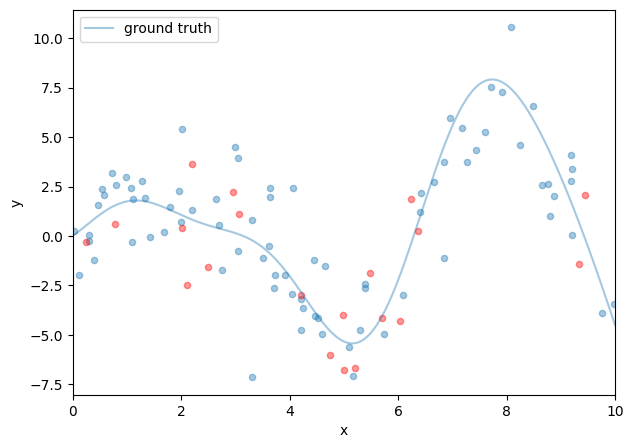

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

FIGSIZE = (7, 5)

def ground_truth(x):
    """Ground truth -- function to approximate"""
    return x * np.sin(x) + np.sin(2 * x)

def gen_data(n_samples=200):
    """generate training and testing data"""
    np.random.seed(15)
    X = np.random.uniform(0, 10, size=n_samples)[:, np.newaxis]
    y = ground_truth(X.ravel()) + np.random.normal(scale=2, size=n_samples)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = gen_data(100)

# plot ground truth
x_plot = np.linspace(0, 10, 500)

# auxiliary function to plot the data and the model predictions

def plot_data(est=None, legend=None, alpha=0.4, s=20):
    """ plot the data and an estimator """
    fig = plt.figure(figsize=FIGSIZE)
    gt = plt.plot(x_plot, ground_truth(x_plot), alpha=alpha, label='ground truth')

    # plot training and testing data
    plt.scatter(X_train, y_train, s=s, alpha=alpha)
    plt.scatter(X_test, y_test, s=s, alpha=alpha, color='red')
    if est is not None:
        print("Train set score: ", est.score(X_train, y_train))
        print("Test set score:  ", est.score(X_test, y_test))
        plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]),
                 label=legend, color='g', alpha=0.9, linewidth=2)
    plt.xlim((0, 10))
    plt.legend(loc='upper left')
    plt.ylabel('y')
    plt.xlabel('x')

# auxiliary function to plot the evolution of the MSE error with the number of trees

def plot_error(estdefault, est=None, train_color='#2c7bb6', test_color='#d7191c'):
    """plot the evolution of the error of a model against the default, on train/test sets"""
    fig = plt.figure(figsize=FIGSIZE)
    ax = plt.gca()

    # test default:
    test_def = np.empty(estdefault.get_num_boosting_rounds())
    train_def = np.empty(estdefault.get_num_boosting_rounds())
    for i in range(estdefault.get_num_boosting_rounds()):
        test_def[i] = mean_squared_error(y_test, estdefault.predict(X_test, iteration_range=(0,i+1)))
        train_def[i] = mean_squared_error(y_train, estdefault.predict(X_train, iteration_range=(0,i+1)))
    ax.plot(np.arange(estdefault.get_num_boosting_rounds()) + 1, test_def, color='#d7191c', label='Test default',
             linewidth=2, alpha=1.0)
    ax.plot(np.arange(estdefault.get_num_boosting_rounds()) + 1, train_def, color='#2c7bb6', label='Train default',
            linewidth=2, alpha=1.0)

    if est is not None:
        test_est = np.empty(est.get_num_boosting_rounds())
        train_est = np.empty(est.get_num_boosting_rounds())
        for i in range(est.get_num_boosting_rounds()):
            test_est[i] = mean_squared_error(y_test, est.predict(X_test, iteration_range=(0,i+1)))
            train_est[i] = mean_squared_error(y_train, est.predict(X_train, iteration_range=(0,i+1)))
        ax.plot(np.arange(est.get_num_boosting_rounds()) + 1, test_est, color='#fdae61', label='Test custom',
                linewidth=2, alpha=1.0)
        ax.plot(np.arange(est.get_num_boosting_rounds()) + 1, train_est, color='#abd9e9', label='Train custom',
                linewidth=2, alpha=1.0)

    ax.set_ylabel('MSE')
    ax.set_xlabel('n_estimators')
    ax.legend(loc='upper right')
    plt.show()

plot_data()

Let's see first how XGBoost fits this dataset with its default hyper-parameters (see below for their values):

Train set score:  0.999986727512837
Test set score:   -0.24654478674110147


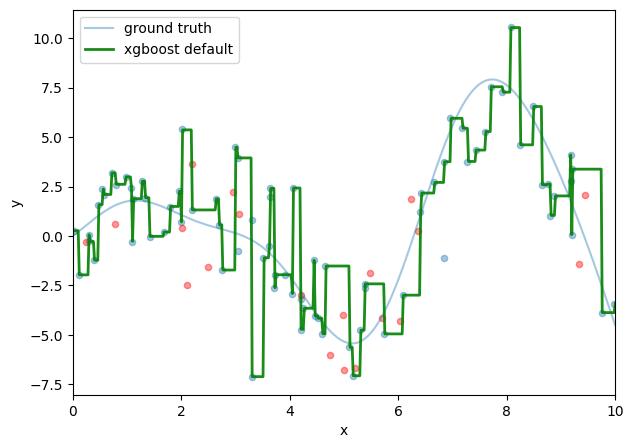

In [ ]:
from xgboost import XGBRegressor
xgbest = XGBRegressor(random_state=RS).fit(X_train, y_train)
plot_data(xgbest, 'xgboost default')

It clearly overfits the data given its default hyper-parameter setting. Let us look at the evolution of the error with the number of trees:

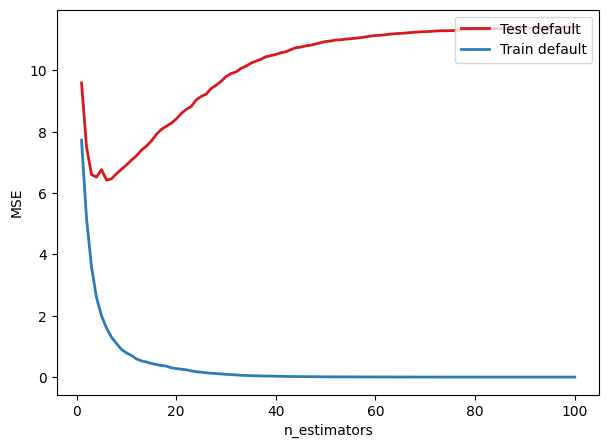

In [ ]:
plot_error(xgbest)

This curve clearly highlights the overfitting. The training error is monotonically decreasing (as expected), while the test error starts increasing already after 10 trees).

Let us look at what RF does in this case, also with default parameter setting:

Train set score:  0.9356437045291799
Test set score:   0.41999534982225073


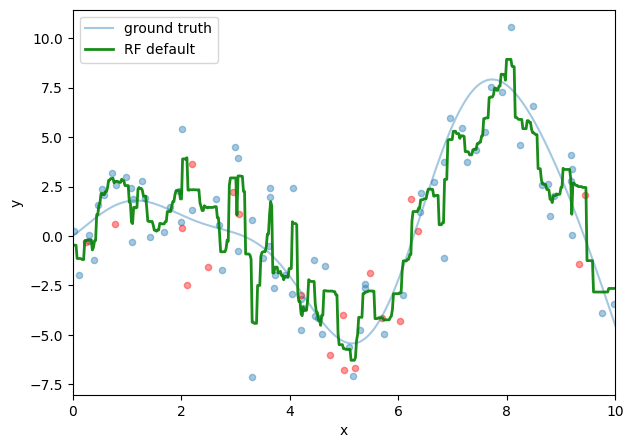

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfest = RandomForestRegressor(random_state=RS).fit(X_train, y_train)
plot_data(rfest, 'RF default')

It also clearly overfits, although less than XGBoost. By now, you should be a RF expert. How can you avoid overfitting here? _(Answer: by reducing tree size in one way or another: try to set max_depth for example to a small value)_


## Playing with the hyper-parameters

Hyper-parameters to avoid overfitting are more numerous in the context of XGBoost (type help(xgbest) in a cell to get the full list or have a look at the XGBoost [documentation](https://xgboost.readthedocs.io/en/stable/parameter.html)). The main ones are the following:
* `max_depth` (default 6): it should be kept very low (from 1 to 6 typically)
* `n_estimators` (default 100): the training error is typically monotonically decreasing with the maximum number of iterations, while unlike with RF, the error on an independent test set will typically start increasing at some point.
* `learning_rate` (default 0.3, between 0 and 1). Allows to avoid overfitting. Smaller values require more trees to reach convergence.
* `gamma` (default 0, between 0 and infinity): the minimum loss reduction for a split to be performed. It allows to stop splitting a node if the split is not informative enough (see the lecture for the complexity penalty term). Values depend on the
* `reg_lambda` (default 1, between 0 and infinity): L2 penalty on the weights (leaf predictions) (see the lecture for the complexity penalty term).
* `colsample_bytree` (default 1): the proportion of features sampled before growing each tree. Equivalent to mtry but at the level of the tree.
* `subsample` (default 1): the proportion of sample drawn (without replacement) before growing each tree.

To get an idea of the impact of these parameters, change the value of one of them (in the xgbestcustom.set_params arguments) and look at the impact on the model predictions and on the evolution of the train and test error with respect to the default setting.

> _For example, we changed below max_depth from 6 (in the default setting) to 1. You see that now, the model actually underfits. One should thus increase the number of iterations to allow it to reach convergence._

Train set score:  0.7701139526064031
Test set score:   0.39249902255847824


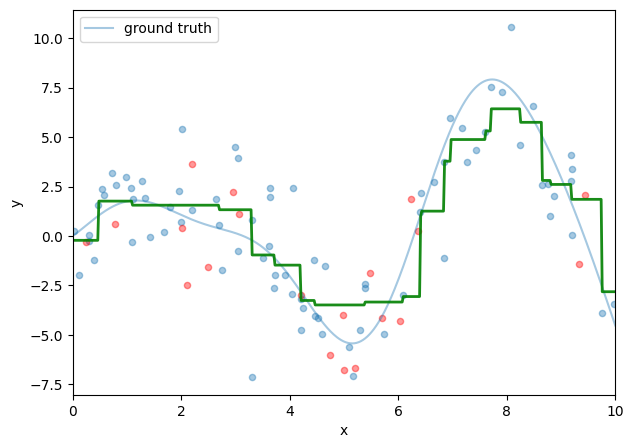

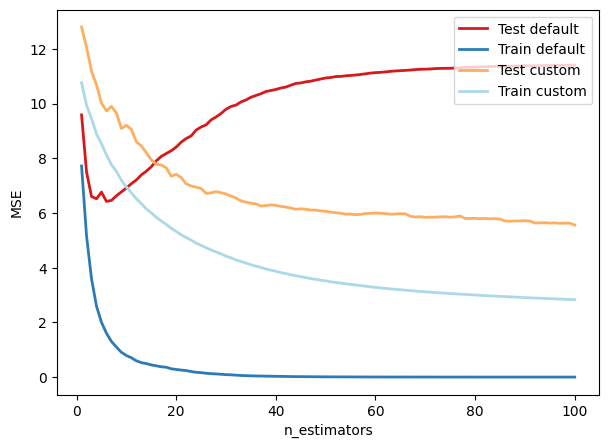

In [ ]:
xgbestdefault = XGBRegressor().fit(X_train, y_train)
xgbestcustom = XGBRegressor()
xgbestcustom.set_params(max_depth=1, n_estimators=100, learning_rate=0.3,
                        gamma=0, reg_lambda=1, subsample=1.0)
xgbestcustom.fit(X_train,y_train)
plot_data(xgbestcustom)
plot_error(xgbestdefault, xgbestcustom)

Try manually to tune the hyper-parameters to obtain the best possible performance on the test set.
> _You should observe that this is very difficult_

## Automatic tuning

A more systematic approach to hyper-parameter tuning is to explore a grid of values of these parameters and to select the best combinations using cross-validation to estimate performance. In the case of boosting, one good approach is to set the number of trees to a large value (e.g., at least 1000), to tune all other parameters and then eventually to increase further the number of estimators and tune again the learning rate. There is also a mechanism of early stopping in XGBoost (not investigated here) that allows to stop the iterations if the error on an independent validation set starts increasing or does not decrease for several iterations. This allows to remove the parameter 'n_estimators' from the grid search.

Parameter tuning can be done in scikit-learn using the GridSearchCV method (_can take some time_)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [1, 2, 3],
              'n_estimators': [2000],
              'subsample': [0.5, 0.75, 1.0]}
gbestcv = XGBRegressor(n_estimators=2000, random_state=RS)
# by default, 5-fold CV is used by GridSearchCV
gs_cv = GridSearchCV(gbestcv, param_grid, scoring='neg_mean_squared_error', verbose=1).fit(X_train, y_train)
# best hyperparameter setting
print("Best param found: ", gs_cv.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best param found:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 2000, 'subsample': 0.5}


Train set score:  0.7607457872003874
Test set score:   0.5060071486555406


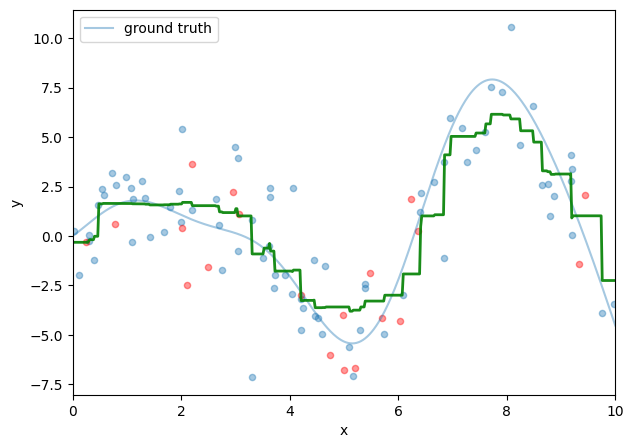

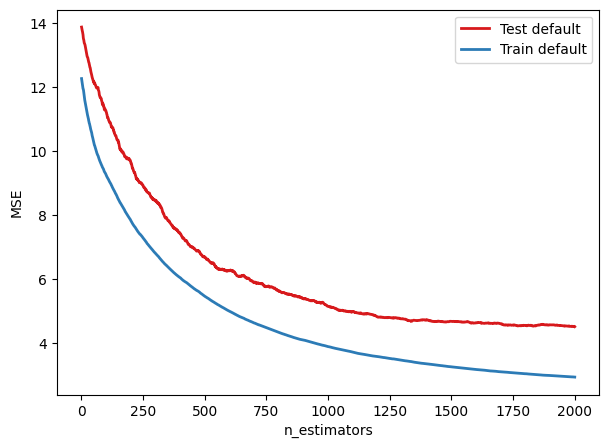

In [ ]:
gbestcv.set_params(**gs_cv.best_params_).fit(X_train, y_train)
plot_data(gbestcv)
plot_error(gbestcv)

Did you manage to get better performance with Random forests on this problem?

# Use-case: Bioresponse dataset

In this last part, we let you try to tune by yourself both RF and XGBoost to get the best performance on one particular dataset. This dataset has been selected given the experiments in the following [paper]().

From the description in [openml](https://www.openml.org/search?type=data&status=active&id=45017):
> The goal of the problem is to predict a biological response of molecules from their chemical properties. Each row in this data set represents a molecule. The first column contains experimental data describing an actual biological response; the molecule was seen to elicit this response (1), or not (0). The remaining columns represent molecular descriptors (d1 through d1776), these are calculated properties that can capture some of the characteristics of the molecule - for example size, shape, or elemental constitution. The descriptor matrix has been normalized.

See [here](https://www.kaggle.com/c/bioresponse) for more information about the problem.


In [ ]:
# fetching the dataset

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from time import process_time

RS = 12345

X, y = fetch_openml(
    data_id=45017, as_frame=True, return_X_y=True, parser="pandas"
)
feature_names = X.columns.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RS)

Default run of XGBoost and random forests:

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

estimator_list = [RandomForestClassifier(random_state=RS),
                  XGBClassifier(random_state=RS)]

results = pd.DataFrame(columns=["Estimator", "Train Acc", "Test Acc", "cpu"])
for est in estimator_list:
    print("Fitting ", est.__class__.__name__,"...")
    t_start = process_time()
    est.fit(X_train, y_train)
    t_stop = process_time()
    results.loc[len(results)] = {"Estimator": est.__class__.__name__,
                                 "Train Acc": est.score(X_train, y_train),
                                 "Test Acc": est.score(X_test, y_test),
                                 "cpu": t_stop-t_start}
results

Fitting  RandomForestClassifier ...
Fitting  XGBClassifier ...


,Estimator,Train Acc,Test Acc,cpu
0,RandomForestClassifier,1.0,0.769499,1.419642
1,XGBClassifier,1.0,0.769499,6.170608


By default, both RF and XGBoost get exactly the same results. Try to tune them and see which one can perform best on this problem.

__This is the end of this practical.__